In [1]:
# with open(oname,'r') as f:
#     lines = f.readlines()
import Bio.SearchIO
import scipy.sparse
from domutil.util import *
import subprocess
import sys
did2node = pk_load('hashcath')
# tm,oms = pk_load('1200seq')

matlist = ['bolsum62_logOFquot.mat',
'bolsum62_quotOFlog',
'bolsum62_quotOFlog_atan',
]



/home/shouldsee/.local/lib/python2.7/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
from tempfile import TemporaryFile , mkdtemp

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def split_file(fname, number = None, linecount = None, delimiter = '\n', 
               header = '\n', footer = '\n',
               start = 0, end = -1):
    if linecount and number:
        raise Exception('You can only specify one of linecount or number')
    f_handles = []
    tempdir = mkdtemp(prefix = '/tmp/feng')
    
#     lcount = file_len(fname)
    with open(fname,'r') as f:
#         lines = f.readlines()
        lines = f.read().split(delimiter)
        lcount = len(lines)
    print tempdir
    print lcount 
#     return
    
    if number:
#         with open(fname) as f:
#             lines = f.readlines()
        lcount = len(lines)
        nlcount = lcount // number + 1
        idxs = range( 0, lcount , nlcount)
        for i,idx in enumerate(idxs):
#             print i
#             if i >= 11:
#                 break

#             f = TemporaryFile()
            temp_fname = tempdir + '/%d'%i
            f = open(temp_fname, 'w+')
            f.write( header)
            f.write( delimiter.join(lines[idx: idx+nlcount]))
            f.write( footer)
#             f.close()
#             f = open(temp_fname,'r')
#             f.seek(0)
            f_handles.append(temp_fname)
    if linecount:
#         idx = start
        idx = 0
        i   = 0
        nlcount = linecount
        while 1:
            temp_fname = tempdir + '/%d'%i
            f = open(temp_fname, 'w' )
            f.write( header)
            f.write( delimiter.join(lines[idx:idx + nlcount]) )
            f.write( footer)
            f.seek(0)
            f_handles.append(temp_fname)
            if idx + nlcount+1 >= lcount : 
                break
            else:
                idx += nlcount
                i   += 1
    return f_handles
import Bio.SeqIO
def hashfasta(fname):
    it = Bio.SeqIO.parse( fname,'fasta' )
    hash2did = {}
    # i = 0
    for i,ent in enumerate(it):
        h = hash(ent.name) 
        hash2did[ h ] = (i,ent.name)
    return hash2did

# def f(oname):
# #     it = Bio.SearchIO.parse( oname,'fasta-m10' )
# #     d = {}
#     it = Bio.SearchIO.parse( oname,'fasta-m10' )
#     l = []
#     for ent in it:
#         hits = ent.__dict__['_items']
#         qid = hash(ent.id)
#         for hit in hits.values():
#             v = hit[0].bitscore
#             jid = hash(hit.id)
#             l += [((qid,jid),v)]
#     #         d[ ( qid, jid) ] = v
#     return l

def f(oname = 'tmp'):
#     oname = 'tmp'
    it = Bio.SearchIO.parse( oname,'fasta-m10' )
    l = []
    for ent in it:
        hits = ent.__dict__['_items']
        qid = hash(ent.id)
        for hit in hits.values():
#             print hit             #### Hit
#             print hit[0].__dict__ #### HSP
#             print hit[0][0]       #### HSPFrag
#             print len(hit[0][0])  #### HSPfrag    
            v = float(hit[0].opt_score)/len(hit[0][0])
#             v = float(hit[0].opt_score)
    
            jid = hash(hit.id)
            l += [ ((qid,jid),v) ]
#         raise Exception('stop')
    return l

def out2dmat( fname,  hash2did, para = 10,
            qfile  = None,libfile = None,):
    def findheader(fname):
        with open(fname,'r') as f:            
            header = ''
            line = f.readline()
            try:
                while not line.startswith('Query'):
                    header += line
                    line = f.readline()            
                header += line
            except Exception as e:
                raise Exception("Unable to grab the header from file :'%s'"%fname + str(e) )
            buf = f.read()
            tmpf = 'parse.tmp'
            with open( tmpf,'w') as of:
                 of.write(buf)
        return header, tmpf
    if isinstance( fname,list):
        f_handles = fname
        tmpf = ''
    else:
#     if 1:
        header,tmpf = findheader(fname)
#         f_handles = split_file( fname, number = para,
#                        delimiter = '>>><<<',
#                        header = header,
#                        footer = '\n>>>///\n',
#                               start = 10,)
        f_handles = split_file( tmpf, number = para,
#                        delimiter = 'Query',
                        delimiter = '>>><<<',
#                        header = header,
                               header  = header,
                       footer = '\n>>>///\n',
                              start = 0,)
        print header

    xs = []
    ys = []
    if para > 1:
        pool = mp.Pool( para )
        res = pool.map( f, f_handles)
        lst = sum( res,[] )
        d = dict(lst)
        pool.close()
#         pool.join()
    else:
        d  = {}
        i = 0
        print 'handles:',f_handles
        for oname in f_handles:        
            print 'now parsing:',oname
            print i
            i += 1
            it = Bio.SearchIO.parse( oname,'fasta-m10' )
            for ent in it:
            #     print ent
                hits = ent.__dict__['_items']
                qid = hash(ent.id)
                for hit in hits.values():
                    v = hit[0].bitscore
                    jid = hash(hit.id)
                    d[ ( qid, jid) ] = v
#         return d
        
    l = len(hash2did)
    om = scipy.sparse.dok_matrix( (l,l) )
    order_d = { (hash2did[k[0]][0],
                hash2did[k[1]][0]):
               v for k,v in d.iteritems()
              }
    om.update(order_d)
    
    if tmpf:
        os.remove(tmpf)
    for tmpf in f_handles:
        os.remove(tmpf)
    return om
################ old routine ########################
# om.mean()
# tm.mean()
# fname = full("$SEQlib/cath-dataset-nonredundant-S40.fa")
def readfasta( fname ):
    with open(fname, 'r') as f:
        lines =  f.readlines()
    seqs = []
    sfs  = []
    data = []
    for i in range(0,len(lines),2):
        header = lines[i].rstrip('\n')
        seq = lines[i+1].rstrip('\n')
#         acc = p_cathFAheader.findall(header)[0]
#         if not acc in did2node:
#             continue    
#         sf = did2node[acc]
        data.append( (i//2, header, seq) ) 
    return data
def writefasta(fname, data):
    with open(fname,'w') as f:
        for i,header,seq in data:
            f.write( '%s\n%s\n' % (header,seq))

def compare( om, tm = None, thres = 0.5):
    tm = tm.tocsr()
    om = om.tocsr()
    tp = ((om + tm)  == 2).sum()
    fp = ((om - tm)  == 1).sum()
    return tp,fp,



def f2(obj):
    x,y = obj
    v = x[-1] == y[-1]
    return ( (x[0],y[0]), v)

import multiprocessing as mp
import multiprocessing as mp
def findtm( hash2head, did2node):
    INPUT = list()
    print len(hash2head)
    for i,head in hash2head.itervalues():
        did = p_cathFAheader.findall(head)[0]
        INPUT += [(i,did2node[did])]
    l = len(INPUT)
#     return INPUT
        # INPUT = hash2did
    it = itertools.combinations( INPUT,2 )
    OUTPUT = scipy.sparse.dok_matrix( ( l, l), )
    d = { (obj[0][0],obj[1][0]):obj[0][-1] == obj[1][-1] for obj in it}
    OUTPUT.update(d)
    tm = OUTPUT
    return tm
# hash2head

In [122]:
    oname = 'tmp'
    it = Bio.SearchIO.parse( oname,'fasta-m10' )
    l = []
    for ent in it:
        hits = ent.__dict__['_items']
        qid = hash(ent.id)
        print ent
        for hit in hits.values():
#             print hit             #### Hit
#             print hit[0].__dict__ #### HSP
#             print hit[0][0]       #### HSPFrag
#             print len(hit[0][0])  #### HSPfrag
    
            v = float(hit[0].opt_score)/len(hit[0][0])
            jid = hash(hit.id)
            l += [((qid,jid),v)]
        raise Exception('stop')
#             break


Program: fasta (36.3.8d)
  Query: cath|4_1_0|1t8oA02/28-120_233-243 (104)
 Target: ./cath-dataset-nonredundant-S40.2000rdtmp
   Hits: 0


Exception: stop

In [124]:
##############################################
### Brew temporary files #####################
##############################################
##############################################
import sys
import os
os.environ['SEQlib'] = '.'
# sys.environs['SEQlib']='.'
forig = full("$SEQlib/cath-dataset-nonredundant-S40.fa")
lnum = 21090
lnum = 2000

ftmp = forig.rstrip('.fa') + '.%drdtmp'%lnum
# raise Exception('stop here')
data = readfasta( forig )
_ = np.random.seed(0)
# ?np.random.choice
idx = np.random.choice(range(0,len(data)), size = lnum, replace = 0)
# idx = np.random.randint( 0 , len(data), lnum,refill = 0)
writefasta(ftmp, [data[i] for i in idx])


# with open( ftmp,'w' ) as fout:   
#     cmd = 'head -n %d %s' % (lnum,forig,)
#     print cmd
#     subprocess.check_call(cmd.split(),stdout = fout)


In [126]:
%%time
import subprocess
import multiprocessing as mp

matDIR = 'submat/'
matlist = ['blosum62_logOFquot.mat',
# 'blosum62_quotOFlog.mat',
'blosum62_quotOFlog_atan.mat',
'blosum62_logOFquot95.mat',
          ]
DIR = 'result'


fname = ftmp
import multiprocessing as mp
print ftmp
num_T = mp.cpu_count() - 1
# num_T = mp.cpu_count() - 1
num_T = 9


assert os.path.isdir(DIR),'Directory not found:"%s"'%DIR

for matname in matlist:
# for num_T in range(1,14,2):
#     matname = matlist[0]
    print num_T
    print matname
#     mat = 
    program = 'ssearch36'
    program = 'fasta36'
    
    cmd = program + ' %s %s -T%d -m10 -f0 -g0 -d0 -z5 -E10 -s %s' % (fname,
                                               fname,
                                                num_T,
                                                matDIR + matname)
    print cmd
    oname = os.path.join(DIR,fname  + '_%s_%s.m10' % (program,matname))
    # buf = open()
    with open(oname,'w') as outf:
        %time subprocess.check_call( cmd.split(), stdin=None, stdout=outf, stderr=None, shell=False)


./cath-dataset-nonredundant-S40.2000rdtmp
9
blosum62_logOFquot.mat
fasta36 ./cath-dataset-nonredundant-S40.2000rdtmp ./cath-dataset-nonredundant-S40.2000rdtmp -T9 -m10 -f0 -g0 -d0 -z5 -E10 -s submat/blosum62_logOFquot.mat
CPU times: user 0 ns, sys: 64 ms, total: 64 ms
Wall time: 1min 14s
9
blosum62_quotOFlog_atan.mat
fasta36 ./cath-dataset-nonredundant-S40.2000rdtmp ./cath-dataset-nonredundant-S40.2000rdtmp -T9 -m10 -f0 -g0 -d0 -z5 -E10 -s submat/blosum62_quotOFlog_atan.mat
CPU times: user 8 ms, sys: 56 ms, total: 64 ms
Wall time: 1min 15s
9
blosum62_logOFquot95.mat
fasta36 ./cath-dataset-nonredundant-S40.2000rdtmp ./cath-dataset-nonredundant-S40.2000rdtmp -T9 -m10 -f0 -g0 -d0 -z5 -E10 -s submat/blosum62_logOFquot95.mat
CPU times: user 0 ns, sys: 64 ms, total: 64 ms
Wall time: 1min 13s
CPU times: user 12 ms, sys: 300 ms, total: 312 ms
Wall time: 3min 43s


In [117]:

om = out2dmat( 'tmp' , hash2head, para = ncore,
    #              qfile = ftmp,
    #              libfile = ftmp
                 )
# om.shape
# oms[0] = om
oms = [om]

/tmp/fengnr1tAT
2001
# fasta36 ./cath-dataset-nonredundant-S40.2000rdtmp ./cath-dataset-nonredundant-S40.2000rdtmp -T9 -m10 -f0 -g0 -d0 -z5 -E10000000 -s submat/blosum62_quotOFlog_atan.mat
FASTA searches a protein or DNA sequence data bank
 version 36.3.8d Apr, 2016(preload9)
Please cite:
 W.R. Pearson & D.J. Lipman PNAS (1988) 85:2444-2448

Query: ./cath-dataset-nonredundant-S40.2000rdtmp



In [103]:
%%time
# forig = full("cath-domain-seqs-S35.fa")
# forig = full("cath-dataset-nonredundant-S40.fa")
# ftmp = forig.rstrip('.fa') + '.tmp'
fname = ftmp
hash2head = hashfasta( ftmp )
# forig = full("$SEQlib/cath-dataset-nonredundant-S40.fa")

# forig = full("$SEQlib/cath-domain-seqs-S35.fa")if ncore:
#     fs = split_file('tmp',ncore, delimiter = '>>><<<')
# else:
oms = []
DIR = 'result'
ncore = mp.cpu_count() - 2

matlist = ['blosum62_logOFquot.mat',
'blosum62_quotOFlog.mat',
'blosum62_quotOFlog_atan.mat',
]
oname
for matname in matlist:
    oname = os.path.join(DIR,fname  + '_%s_%s.m10' % (program,matname))
#     oname = os.path.join(DIR, fname  + '_%s.m10' % matname)
    print oname
    assert os.path.isfile(oname)

    om = out2dmat( oname , hash2head, para = ncore,
    #              qfile = ftmp,
    #              libfile = ftmp
                 )
    oms += [om]
    print 'Done'

%time tm = findtm( hash2head,did2node )
print 'Done'


result/./cath-dataset-nonredundant-S40.2000rdtmp_fasta36_blosum62_logOFquot.mat.m10
/tmp/fengkNAArT
2001
# fasta36 ./cath-dataset-nonredundant-S40.2000rdtmp ./cath-dataset-nonredundant-S40.2000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_logOFquot.mat
FASTA searches a protein or DNA sequence data bank
 version 36.3.8d Apr, 2016(preload9)
Please cite:
 W.R. Pearson & D.J. Lipman PNAS (1988) 85:2444-2448

Query: ./cath-dataset-nonredundant-S40.2000rdtmp

Done
result/./cath-dataset-nonredundant-S40.2000rdtmp_fasta36_blosum62_quotOFlog.mat.m10
/tmp/feng_3KCbD
2001
# fasta36 ./cath-dataset-nonredundant-S40.2000rdtmp ./cath-dataset-nonredundant-S40.2000rdtmp -T9 -m10 -f0 -g0 -z5 -E100 -s submat/blosum62_quotOFlog.mat
FASTA searches a protein or DNA sequence data bank
 version 36.3.8d Apr, 2016(preload9)
Please cite:
 W.R. Pearson & D.J. Lipman PNAS (1988) 85:2444-2448

Query: ./cath-dataset-nonredundant-S40.2000rdtmp

Done
result/./cath-dataset-nonredundant-S40.2000rdtmp_fasta36_blosu

In [32]:
import multiprocessing as mp
def findtm( hash2head, did2node):
    INPUT = list()
    print len(hash2head)
    for i,head in hash2head.itervalues():
        did = p_cathFAheader.findall(head)[0]
        INPUT += [(i,did2node[did])]
    l = len(INPUT)
#     return INPUT
        # INPUT = hash2did
    it = itertools.combinations( INPUT,2 )
    OUTPUT = scipy.sparse.dok_matrix( ( l, l), )
    d = { (obj[0][0],obj[1][0]):obj[0][-1] == obj[1][-1] for obj in it}
    OUTPUT.update(d)
    tm = OUTPUT
    return tm
#     it = itertools.combinations( INPUT,2 )
#     # it = itertools.combinations( data[:l],2 )
#     pool = mp.Pool(12)
#     # res = pool.apply_async(f, it)      # runs in *only* one process
#     # print res.get(timeout=1)              # prints "400"
#     res = pool.map(f2, (it) )
#     pool.close()
#     pool.join()
#     OUTPUT = scipy.sparse.dok_matrix( ( l, l), )
#     # OUTPUT.update( res )
#     OUTPUT.update({x:y for x,y in res})
#     tm = OUTPUT
#     return tm
# %time tmt = findtm( hash2head,did2node )
print 'Done'


5000
CPU times: user 8.93 s, sys: 2.19 s, total: 11.1 s
Wall time: 11.1 s
Done


In [ ]:
# tm = tmt
print oms[0].shape
print tm.shape

In [118]:
%%time
tm = tm.tocsr()
xss = []
yss = []
for om in oms[:]:
#     d = scipy.sparse.dok_matrix( (l,l) )
#     d.update(
#         { (idxD[i],idxD[j]):v for (i,j),v in om.iteritems()}
#     )
#     om = d.tocsr()
    om = om.tocsr()
    thres = 1  
    xs = []
    ys = []
    it = np.linspace( om.min(), om.max(), 50)
    for thres in it:
        tp,fp = compare( om > thres ,tm)
        xs += [fp]
        ys += [tp] 
    xss += [xs]
    yss += [ys]
    print "finished"
    

finished
CPU times: user 1.28 s, sys: 24 ms, total: 1.31 s
Wall time: 1.31 s


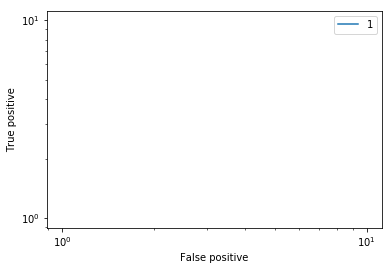

In [119]:
# compare(tm ,om)
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = plt.subplot(111)
ax1.set_xlabel('False positive')
ax1.set_ylabel('True positive')
ax1.set_xscale('log')
ax1.set_yscale('log')

lbl = 0
for xs,ys in izip(xss,yss):
    lbl += 1
    if lbl ==6:
        break
    ax1.plot(xs,ys, label = lbl)
# ax1.set_ylim(bottom = 40)
# ax1.set_ylim(bottom = 40)
# ax1.set_xlim(left = 100)

ax1.legend()

# np.mean(tm.todense())

In [159]:
########################################################
########################################################
### Hack to parse FASTA-m10 into data,frame ###
########################################################
########################################################
########################################################

class fastaLib(object):
    def __init__(self,fname,tmpdir = 'data'):
        self._make_name_dict(fname)
    def _make_name_dict(self,fname):
        self.name_dict = hashfasta( fname )
#         pk.dump(name_dict)

def func(oname):
#     it = Bio.SearchIO.parse( oname,'fasta-m10' )
#     d = {}
    it = Bio.SearchIO.parse( oname,'fasta-m10' )
    l = []
    i = 0
#     print sum(1 for _ in it)
    for ent in it:
        hits = ent.__dict__['_items']
#         qid = hash(ent.id)
#         l += [(ent.id,ent)]
#         continue
        query_id = ent.id
        for hit in hits.values():
            v = hit[0]
#             v.__dict__.update({"query_id":ent.id,"hit_id":hit.id})
#             dct = {"query_id":ent,"hit_id":hit}
#             v.__dict__.pop('_items')
#             dct.update(v.__dict__)
# #             dct.update({"query_id":ent.id,"hit_id":hit.id})
# #             dct.pop('_items')
#             l += [dct]
            v.__dict__.update({"query_id":query_id,
                              "hit_id":hit.id})
            v.__dict__.pop('_items')
            l += [v.__dict__]
#             l += [((ent.id,hit_id),v)]
#             jid = hash(hit.id)
#             l += [((qid,jid),v)]
#         i += 1
#         print i
#     print len(l)
    return l


def out2dmat( fname,  hash2did = None, para = 10, func = func,
            qfile  = None,libfile = None,):
    def findheader(fname):
        with open(fname,'r') as f:            
            header = ''
            line = f.readline()
            try:
                while not line.startswith('Query'):
                    header += line
                    line = f.readline()            
                header += line
            except Exception as e:
                raise Exception("Unable to grab the header from file :'%s'"%fname + str(e) )
            buf = f.read()
            tmpf = 'parse.tmp'
            with open( tmpf,'w') as of:
                 of.write(buf)
        return header, tmpf
    if isinstance( fname,list):
        f_handles = fname
        tmpf = ''
    else:
#     if 1:
        header,tmpf = findheader(fname)
#         f_handles = split_file( fname, number = para,
#                        delimiter = '>>><<<',
#                        header = header,
#                        footer = '\n>>>///\n',
#                               start = 10,)
        f_handles = split_file( tmpf, number = para,
#                        delimiter = 'Query',
                        delimiter = '>>><<<',
#                        header = header,
                               header  = header,
                       footer = '\n>>>///\n',
                              start = 0,)
        print header

    xs = []
    ys = []
    d  = {}
    if para > 1:
        pool = mp.Pool( para )
        res = pool.map( func, f_handles)
        lst = sum( res,[] )        
        pool.close()
#         pool.join()
    else:
        lst = []
        i = 0
        print 'handles:',f_handles
        for oname in f_handles:        
            print 'now parsing:',oname
            print i
            i += 1
            lst += func(oname)
#             d.update(dict(lst))
#             it = Bio.SearchIO.parse( oname,'fasta-m10' )
#             for ent in it:
#             #     print ent
#                 hits = ent.__dict__['_items']
#                 qid = hash(ent.id)
#                 for hit in hits.values():
#                     v = hit[0].bitscore
#                     jid = hash(hit.id)
#                     d[ ( qid, jid) ] = v
    return lst
    d.update(dict(lst))
    return d
        
    l = len(hash2did)
    om = scipy.sparse.dok_matrix( (l,l) )
    order_d = { (hash2did[k[0]][0],
                hash2did[k[1]][0]):
               v for k,v in d.iteritems()
              }
    om.update(order_d)
    
    if tmpf:
        os.remove(tmpf)
    for tmpf in f_handles:
        os.remove(tmpf)
    return om

In [161]:
from tempfile import TemporaryFile , mkdtemp

fout = "ggsearch.m10"
fout = "ggsearch_aln.m10"
fout = "fasta36_aln.m10"
fout = "fasta36_aln_BAphid.m10"

fas1 = "Buchnera_aphidicola_bcc.ASM9096v1.cdna.all.fa"
fas2 = "Escherichia_coli_str_k_12_substr_mds42.GCA_000350185.1.23.cdna.all.names.fa"


# hash2head = hashfasta()
# fasta
# f_handles = split_file( fout, 100, delimiter = '>>><<<')
# fout = f_handles[1]
dout = out2dmat(fout,para = 6)

# fas1 = fastaLib(fas1)
# fas2 = fastaLib(fas2)
# import os
print "Done"
# dout



/tmp/fengE4u7Qr
366
# fasta36 Buchnera_aphidicola_bcc.ASM9096v1.cdna.all.fa Escherichia_coli_str_k_12_substr_mds42.GCA_000350185.1.23.cdna.all.names.fa -m10 -T7 -n
FASTA searches a protein or DNA sequence data bank
 version 36.3.8d Apr, 2016(preload9)
Please cite:
 W.R. Pearson & D.J. Lipman PNAS (1988) 85:2444-2448

Query: Buchnera_aphidicola_bcc.ASM9096v1.cdna.all.fa

Done


In [165]:
# len(dout)
import matplotlib
matplotlib.style.use('ggplot')
# dcts = [x.__dict__ for x in dout]
dcts = dout
df = pd.DataFrame(dcts)
df['query_id'] = df['query_id'].astype(object)
df['hit_id'] = df['hit_id'].astype(object)
df.head()
# df.boxplot
# dout[0].__dict__

,bitscore,evalue,hit_id,ident_pct,init1_score,initn_score,opt_score,pos_pct,query_id,z_score
0,445.5,5.200000e-125,gidA,54.5,663,1004,1662,54.5,ABJ90487,2335.3
1,45.6,1.300000e-04,ygeF,58.0,76,146,155,58.0,ABJ90487,185.3
2,42.5,1.100000e-03,rfaK,58.6,85,216,153,58.6,ABJ90487,161.7
3,40.3,5.000000e-03,rfaS,55.2,93,129,169,55.2,ABJ90487,150.8
4,39.5,8.400000e-03,yddJ,57.5,85,135,133,57.5,ABJ90487,154.8


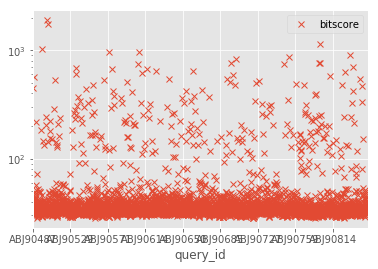

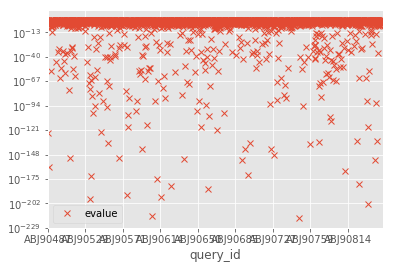

In [200]:
# df.plot.scatter(x='query_id', y='bitscore');
df.plot(x='query_id', y='bitscore',style='x'
       ,logy = 'true')
df.plot(x='query_id', y='evalue',style='x'
       ,logy = 'true')
# ?df.plot
# pl.xticks(x,xticks)

In [201]:
# df.agg({'query_id':['sum', 'min']})
# ?df.agg
df2  = df.groupby(['query_id'],as_index=False).min()
df2.head()
# df2['index']


,query_id,bitscore,evalue,hit_id,ident_pct,init1_score,initn_score,opt_score,pos_pct,z_score
0,AAR99732,31.4,6.000000e-155,djlC,53.3,71,71,104,53.3,100.3
1,AAR99733,30.6,3.300000e-02,ybiN,54.6,69,121,101,54.6,105.0
2,AAR99734,31.3,2.600000e-92,leuB,54.3,65,108,103,54.3,101.7
3,AAR99735,32.0,1.700000e-133,envR,56.0,91,115,106,56.0,111.2
4,AAR99736,30.0,6.800000e-37,cmtB,54.1,60,95,99,54.1,102.0


In [225]:
# df2['evalue'].max()



,bitscore,evalue,hit_id,ident_pct,init1_score,initn_score,opt_score,pos_pct,query_id,z_score
0,445.5,5.200000e-125,gidA,54.5,663,1004,1662,54.5,ABJ90487,2335.3
14,572.1,5.200000e-163,gyrB,58.4,224,502,2056,58.4,ABJ90488,3015.7
28,49.1,6.300000e-06,rfaK,58.4,90,241,171,58.4,ABJ90489,201.9
44,218.1,1.000000e-56,dnaA,54.5,111,156,778,54.5,ABJ90490,1111.6
58,72.0,1.000000e-13,rpmH,69.4,200,200,249,69.4,ABJ90491,357.7
61,52.9,1.500000e-07,rnpA,59.4,117,152,181,59.4,ABJ90492,239.8
74,50.5,1.900000e-06,yjgL,54.9,128,191,178,54.9,ABJ90493,207.3
90,49.7,5.300000e-06,rfaS,55.9,81,159,205,55.9,ABJ90494,204.4
107,183.1,7.800000e-47,groS,69.0,631,631,651,69.0,ABJ90495,946.4
120,1024.7,0.000000e+00,groL,69.4,3376,3376,3690,69.4,ABJ90496,5467.8


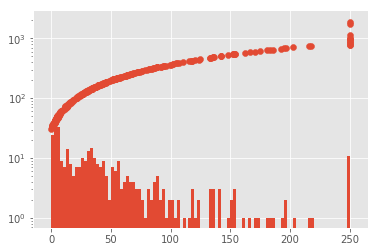

In [261]:
# idx = df.groupby(['query_id'])['evalue'].transform(min) == df['evalue']
idx = df.groupby(['query_id'])['bitscore'].transform(max) == df['bitscore']
df2 = df[idx]
# df2.__len__()
# help(df2['evalue'].hist)
# ()
df2['evalue'].transform(lambda x: -np.log10(x) if x else 250 ).hist(bins = 100)
# df2['bitscore'].hist(bins = 100)
plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')

# df2  = df.groupby(['query_id'],as_index=False).agg({'bitscore':'max','evalue':'min'})
# df2
plt.scatter(x = df2['evalue'].transform(lambda x: -np.log10(x) if x else 250 ),
           y = df2['bitscore'])

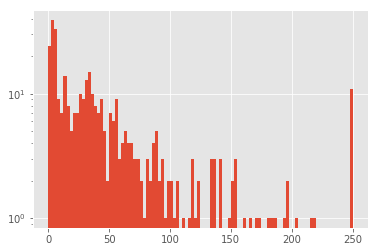

In [257]:
# idx = df.groupby(['query_id'])['evalue'].transform(min) == df['evalue']
idx = df.groupby(['query_id'])['bitscore'].transform(max) == df['bitscore']
df2 = df[idx]
# df2.__len__()
# help(df2['evalue'].hist)
# ()
df2['evalue'].transform(lambda x: -np.log10(x) if x else 250 ).hist(bins = 100)
# df2['bitscore'].hist(bins = 100)
plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')

# df2  = df.groupby(['query_id'],as_index=False).agg({'bitscore':'max','evalue':'min'})
# df2


In [ ]:
df2['evalue'].hist

In [214]:
df2  = df.groupby(['query_id'],as_index=False).agg({'bitscore':'max','evalue':'min'})
df2.__len__()

365

In [223]:
set(df['query_id']).__len__()

365

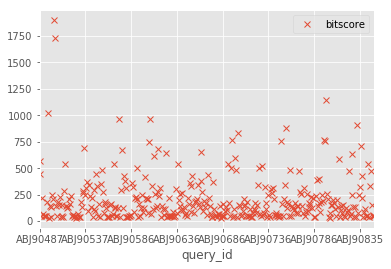

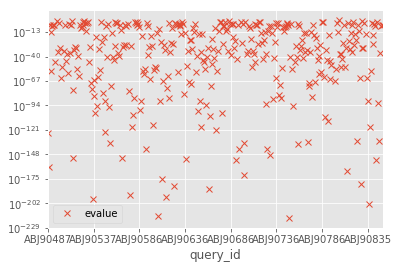

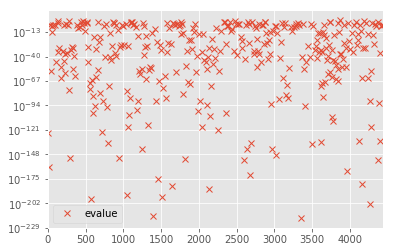

In [221]:
# df.plot.scatter(x='query_id', y='bitscore');
# df2  = df.groupby(['query_id'],as_index=False).min()

df2.plot(x='query_id', y='bitscore',style='x')
df2.plot(x='query_id', y='evalue',style='x'
       ,logy = 'true')
df2.plot(x=df2.index, y='evalue',style='x'
       ,logy = 'true')
# ?df.plot
# pl.xticks(x,xticks)

In [ ]:
from pandas import DataFrame, read_csv

# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas

# The inital set of baby names and bith rates


In [92]:
next(df[1][0].iteritems())

('dapA', Hit(id='dapA', query_id='ABJ90538', 1 hsps))

In [16]:
it = dout.iteritems()
k,v = next(it)


# next(it)[1].hit_id

In [ ]:
print k
print (hash(v.query_id), hash(v.hit_id))
# v.query_id

In [57]:
it = dout.iteritems()
vs = [v.evalue for k,v in it]
# vs = [v.bitscore for k,v in it]

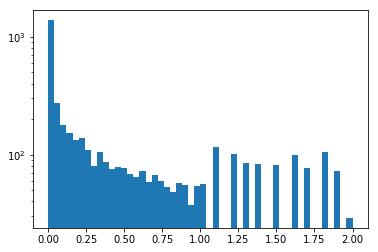

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
vs = np.array(vs)
# plt.hist( vs[ vs > 45 ], 50);
plt.hist( vs, 50);
plt.gca().set_yscale("log")
# plt.gca().set_xscale("log")

In [163]:
for f in f_handles:
    os.remove(f)
print "Done"

Done


In [141]:
#     oname = "ggsearch.m10"
# oname = "ggsearch_aln.m10"
oname = "fasta36_aln.m10"
it = Bio.SearchIO.parse( oname,'fasta-m10' )
l = []
for ent in it:
    hits = ent.__dict__['_items']
    qid = hash(ent.id)
    print ent
    for hit in hits.values():
#             print hit             #### Hit
        print hit[0].__dict__ #### HSP
#             print hit[0][0]       #### HSPFrag
#             print len(hit[0][0])  #### HSPfrag

        v = float(hit[0].opt_score)/len(hit[0][0])
        jid = hash(hit.id)
        l += [((qid,jid),v)]
    if len(hits) > 0:
        raise Exception('stop')
#             break


Program: fasta (36.3.8d)
  Query: thrL (66)
         BAL37321 cdna:novel chromosome:GCA_000350185.1:Chromosome:190:255:1...
 Target: Buchnera_aphidicola_bcc.ASM9096v1.cdna.all.fa
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0      1  ABJ90496  cdna:annotated chromosome:ASM9096v1:Chromosom...
            1      1  ABJ90656  cdna:annotated chromosome:ASM9096v1:Chromosom...
            2      1  ABJ90606  cdna:annotated chromosome:ASM9096v1:Chromosom...
            3      1  ABJ90489  cdna:annotated chromosome:ASM9096v1:Chromosom...
            4      1  ABJ90792  cdna:annotated chromosome:ASM9096v1:Chromosom...
            5      1  ABJ90503  cdna:annotated chromosome:ASM9096v1:Chromosom...
            6      1  ABJ90808  cdna:annotated chromosome:ASM9096v1:Chromosom...
            7      1  ABJ90676  cdna:annotated chromo

Exception: stop